In [5]:
from sklearn import metrics
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants
import os 
from matplotlib import cm
import glob
import pickle
seed = 2023

In [6]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [7]:
def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [8]:
def compute_roc_auc(group1,group2):
    rng = np.random.default_rng(seed=seed)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]

        # Wilcoxon rank-sum 
        p.append(stats.ttest_ind(g1, g2)[1])#stats.ttest_ind

        thresholds = np.unique(np.concatenate([g1,g2]))

        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
                      
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
        
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    return roc_score, p


In [9]:
def definelatencies(p_values, win, threshold):

   lat=[]

   for i in np.arange(p_values.shape[0]):
      
      tmp=[]
      
      sig=np.zeros(p_values.shape[1])
      sig[np.where(p_values[i,:]<0.01)]=1
      
      for i_step in np.arange(sig.shape[0]):
         if sig[i_step]==1 and np.sum(sig[i_step:i_step+win])>=threshold:
            tmp.append(i_step)  

      if not tmp:
         lat.append(np.nan)  
      else:
         lat.append(tmp[0])  
      
   lat=np.array(lat)

   return lat


In [ ]:
def analyses_per_area(paths, time_before_sample, time_before_t1, timetotal_sample, timetotal_t1, win, step, numcells):
    
    code=1
    select_block=1
    # time_before_sample  =   400
    # time_before_t1      =   450

    # timetotal_sample=   time_before_sample+450*3
    # timetotal_t1    =   time_before_t1+450*2
    # win=100
    # step=1
    
    
    all_s_orient_value      =   np.empty((numcells,timetotal_sample-win,))*np.nan
    all_s_color_value       =   np.empty((numcells,timetotal_sample-win,))*np.nan
    all_s_neutral_value     =   np.empty((numcells,timetotal_sample-win,))*np.nan
    all_s_pos_value         =   np.empty((numcells,timetotal_sample-win,))*np.nan

    all_s_orient_p          =   np.empty((numcells,timetotal_sample-win,))*np.nan
    all_s_color_p           =   np.empty((numcells,timetotal_sample-win,))*np.nan
    all_s_neutral_p         =   np.empty((numcells,timetotal_sample-win,))*np.nan
    all_s_pos_p             =   np.empty((numcells,timetotal_sample-win,))*np.nan

    all_t_orient_value      =   np.empty((numcells,timetotal_t1-win,))*np.nan
    all_t_color_value       =   np.empty((numcells,timetotal_t1-win,))*np.nan
    all_t_neutral_value     =   np.empty((numcells,timetotal_t1-win,))*np.nan
    all_t_pos_value         =   np.empty((numcells,timetotal_t1-win,))*np.nan

    all_t_orient_p          =   np.empty((numcells,timetotal_t1-win,))*np.nan
    all_t_color_p           =   np.empty((numcells,timetotal_t1-win,))*np.nan
    all_t_neutral_p         =   np.empty((numcells,timetotal_t1-win,))*np.nan
    all_t_pos_p             =   np.empty((numcells,timetotal_t1-win,))*np.nan
    id=[]
    meaninsp=[]
    
    n=0
    for p in paths[:numcells]:
        print(str(n) + "/" + str(len(paths)))
        good, mua = 1, 1
        neu_data    =   NeuronData.from_python_hdf5(p)
        date_time   =   neu_data.date_time
        
        neu_data.cluster_group
        neu_data.cluster_number
        if neu_data.cluster_group == "good":
            good += 1
            cluster = "neuron"

        else:
            mua += 1
        
        sp_sample_in_on,mask_sample_in = align_trials.align_on(
                sp_samples=neu_data.sp_samples,
                code_samples=neu_data.code_samples,
                code_numbers=neu_data.code_numbers,
                trial_error=neu_data.trial_error,
                block=neu_data.block,
                pos_code=neu_data.pos_code,
                select_block= select_block,
                select_pos= code,
                event ="sample_on",
                time_before = time_before_sample,
                error_type= 0,
            )

        sp_sample_out_on,mask_sample_out = align_trials.align_on(
                sp_samples=neu_data.sp_samples,
                code_samples=neu_data.code_samples,
                code_numbers=neu_data.code_numbers,
                trial_error=neu_data.trial_error,
                block=neu_data.block,
                pos_code=neu_data.pos_code,
                select_block= select_block,
                select_pos= -1,
                event ="sample_on",
                time_before = time_before_sample,
                error_type= 0,
            )
        
        sp_t1_in_on,mask_t1_in = align_trials.align_on(
                sp_samples=neu_data.sp_samples,
                code_samples=neu_data.code_samples,
                code_numbers=neu_data.code_numbers,
                trial_error=neu_data.trial_error,
                block=neu_data.block,
                pos_code=neu_data.pos_code,
                select_block= select_block,
                select_pos= code,
                event ="test_on_1",
                time_before = time_before_t1,
                error_type= 0,
            )
        
        sp_t1_out_on,mask_t1_in = align_trials.align_on(
                sp_samples=neu_data.sp_samples,
                code_samples=neu_data.code_samples,
                code_numbers=neu_data.code_numbers,
                trial_error=neu_data.trial_error,
                block=neu_data.block,
                pos_code=neu_data.pos_code,
                select_block= select_block,
                select_pos= -1,
                event ="test_on_1",
                time_before = time_before_t1,
                error_type= 0,
            )

        o1trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==1)
        o5trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==5)
        
        c1trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==1)
        c5trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==5)
        
        ntrials     =   np.where(neu_data.sample_id[mask_sample_in]==0)
        nntrials    =   np.where(neu_data.sample_id[mask_sample_in]!=0)



        sample_in_avg_sp   =   moving_average(data=sp_sample_in_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
        sample_out_avg_sp   =   moving_average(data=sp_sample_out_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
        t1_in_avg_sp       =   moving_average(data=sp_t1_in_on[:, :timetotal_t1],win=win, step=step)[:,:-win]
        t1_out_avg_sp       =   moving_average(data=sp_t1_out_on[:, :timetotal_t1],win=win, step=step)[:,:-win]
        
        s_color, p_s_color  =   compute_roc_auc(sample_in_avg_sp[c1trials, :][0], sample_in_avg_sp[c5trials, :][0])
        s_orient,p_s_orient =   compute_roc_auc(sample_in_avg_sp[o1trials, :][0], sample_in_avg_sp[o5trials, :][0])
        sample_s_neutral, p_s_sample_neutral    =   compute_roc_auc(sample_in_avg_sp[nntrials, :][0], sample_in_avg_sp[ntrials, :][0])
        s_pos, p_s_pos      =   compute_roc_auc(sample_in_avg_sp, sample_out_avg_sp)

        t_color, p_t_color  = compute_roc_auc(t1_in_avg_sp[c1trials, :][0], t1_in_avg_sp[c5trials, :][0])
        t_orient,p_t_orient = compute_roc_auc(t1_in_avg_sp[o1trials, :][0], t1_in_avg_sp[o5trials, :][0])
        sample_t_neutral, p_t_sample_neutral    =   compute_roc_auc(t1_in_avg_sp[nntrials, :][0], t1_in_avg_sp[ntrials, :][0])
        t_pos, p_t_pos  = compute_roc_auc(t1_in_avg_sp, t1_out_avg_sp)

        all_s_orient_value[n, :]    =   s_orient
        all_s_color_value[n, :]     =   s_color
        all_s_neutral_value[n, :]   =   sample_s_neutral
        all_s_pos_value[n,:]        =   s_pos

        all_s_orient_p[n, :]        =   p_s_orient
        all_s_color_p[n, :]         =   p_s_color
        all_s_neutral_p[n, :]       =   p_s_sample_neutral
        all_s_pos_p[n,:]            =   p_s_pos

        all_t_orient_value[n, :]    =   t_orient
        all_t_color_value[n, :]     =   t_color
        all_t_neutral_value[n, :]   =   sample_t_neutral
        all_t_pos_value[n,:]        =   t_pos

        all_t_orient_p[n, :]        =   p_t_orient
        all_t_color_p[n, :]         =   p_t_color
        all_t_neutral_p[n, :]       =   p_t_sample_neutral
        all_t_pos_p[n,:]            =   p_t_pos
        
        id.append(date_time[:10] + '_'+ neu_data.cluster_group + '_'+ str(neu_data.cluster_number))
        meaninsp.append(np.nanmean(sp_sample_in_on[:, :timetotal_sample]*1000))
        n+=1
        
    lat_orient  =   definelatencies(all_s_orient_p, win=75, threshold=75)
    lat_color   =   definelatencies(all_s_color_p, win=75, threshold=75)
    lat_neutral =   definelatencies(all_s_neutral_p, win=75, threshold=75)
    lat_pos     =   definelatencies(all_s_pos_p, win=75, threshold=75)

    sample_s_ROC_values =   ["ROC value sample neutral", all_s_neutral_value, "ROC value sample orient", all_s_orient_value, "ROC value sample color", all_s_color_value, "ROC value sample position", all_s_pos_value]
    sample_s_ROC_p      =   ["p value sample neutral", all_s_neutral_p, "p value sample orient", all_s_orient_p, "p value sample color", all_s_color_p, "p value sample position", all_s_pos_p]
    sample_t_ROC_values =   ["ROC value t1 neutral", all_t_neutral_value, "ROC value T1 orient", all_t_orient_value, "ROC value T1 color", all_t_color_value, "ROC value T1 position", all_t_pos_value]
    sample_t_ROC_p      =   ["p value t1 neutral", all_t_neutral_p, "p value T1 orient", all_t_orient_p, "p value T1 color", all_t_color_p, "p value T1 position", all_t_pos_p]
    sample_latencies    =   ["Neutral sample lat", lat_neutral, "orient sample lat", lat_orient, "color sample lat", lat_color, "pos sample lat", lat_pos]

    sample_ROC_analyses  =   [sample_s_ROC_values, sample_s_ROC_p, sample_t_ROC_values, sample_t_ROC_p, sample_latencies,meaninsp, id]

    return sample_ROC_analyses

In [10]:
directory_b1    =   "W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/"
bhv_directory   =   os.path.normpath(str(directory_b1) +  "/bhv/")

area="pfc"
neurons_pfc_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
neurons_pfc_files     =   glob.glob(neurons_pfc_directory, recursive=True)

area="v4"
neurons_v4_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
neurons_v4_files     =   glob.glob(neurons_v4_directory, recursive=True)

area="lip"
neurons_lip_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
neurons_lip_files     =   glob.glob(neurons_lip_directory, recursive=True)

In [23]:
pfc_sample_ROC_analyses=analyses_per_area(paths=neurons_pfc_files, time_before_sample=400, time_before_t1=450, timetotal_sample=400+450*3, timetotal_t1=450+450*2, win=100, step=1, numcells=1)
# with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/v4sampleROC", "wb") as fp: 
#     pickle.dump(pfc_sample_ROC_analyses, fp)

0/1478


In [ ]:
v4_sample_ROC_analyses=analyses_per_area(paths=neurons_v4_files, time_before_sample=400, time_before_t1=450, timetotal_sample=400+450*3, timetotal_t1=450+450*2, win=100, step=1, numcells=1)
# with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/v4sampleROC", "wb") as fp: 
#     pickle.dump(v4_sample_ROC_analyses, fp)

In [ ]:
lip_sample_ROC_analyses=analyses_per_area(paths=neurons_lip_files, time_before_sample=400, time_before_t1=450, timetotal_sample=400+450*3, timetotal_t1=450+450*2, win=100, step=1, numcells=1)
# with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/v4sampleROC", "wb") as fp: 
#     pickle.dump(lip_sample_ROC_analyses, fp)

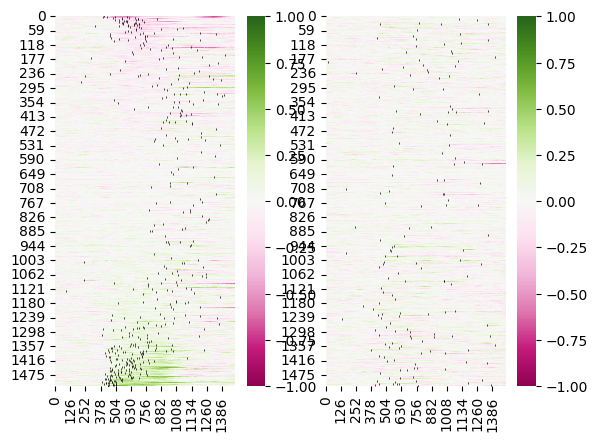

In [ ]:
# plot pfc

sort_neutral    =   np.argsort(np.mean(all_pfc_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_pfc_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_pfc_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_pfc_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_pfc_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_pfc_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_pfc_neutral[sort_neutral], np.arange(lat_pfc_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_pfc_orient[sort_orient], np.arange(lat_pfc_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_pfc_color[sort_color], np.arange(lat_pfc_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_pfc.pdf')  


In [ ]:
# plot v4

sort_neutral    =   np.argsort(np.mean(all_v4_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_v4_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_v4_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_v4_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_v4_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_v4_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_v4_neutral[sort_neutral], np.arange(lat_v4_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_v4_orient[sort_orient], np.arange(lat_v4_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_v4_color[sort_color], np.arange(lat_v4_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_v4.pdf')  


In [3]:

sns.heatmap(all_lip_s_neutral_value[sort_neutral,:],cmap='PiYG',vmin=-1,vmax=1)#,yticklabels=np.arange(len(all_ang[idx_c_o_sort])))

NameError: name 'all_lip_s_neutral_value' is not defined

In [2]:
# plot LIP

sort_neutral    =   np.argsort(np.mean(all_lip_s_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_lip_s_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_lip_s_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))

im0       =   ax[0].imshow(all_lip_s_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_lip_s_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_lip_s_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_lip_neutral[sort_neutral], np.arange(lat_lip_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_lip_orient[sort_orient], np.arange(lat_lip_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_lip_color[sort_color], np.arange(lat_lip_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_lip.pdf')  


NameError: name 'all_lip_s_neutral_value' is not defined

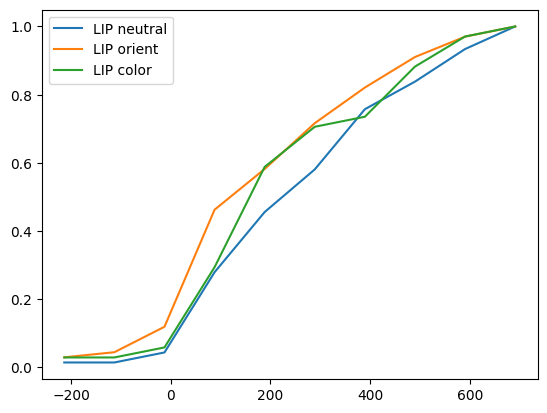

In [ ]:

count_lip_neutral, bins_count = np.histogram(lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)], bins=10) 
pdf_lip_neutral = count_lip_neutral / sum(count_lip_neutral) 
cdf_lip_neutral = np.cumsum(pdf_lip_neutral) 

count_lip_orient, bins_count = np.histogram(lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)], bins=10) 
pdf_lip_orient = count_lip_orient / sum(count_lip_orient) 
cdf_lip_orient = np.cumsum(pdf_lip_orient) 

count_lip_color, bins_count = np.histogram(lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)], bins=10) 
pdf_lip_color = count_lip_color / sum(count_lip_color) 
cdf_lip_color = np.cumsum(pdf_lip_color) 

plt.plot(bins_count[1:]-400, cdf_lip_neutral, label="LIP neutral") 
plt.plot(bins_count[1:]-400, cdf_lip_orient, label="LIP orient") 
plt.plot(bins_count[1:]-400, cdf_lip_color, label="LIP color") 
plt.legend() 